### **Loading Dataset**

Load module and package

In [17]:
!pip install torchmetrics

   ---------------------------------------- 0.0/840.4 kB ? eta -:--:--
   ---------------------------------------- 10.2/840.4 kB ? eta -:--:--
   ---------------------------------------- 10.2/840.4 kB ? eta -:--:--
   - ------------------------------------- 30.7/840.4 kB 330.3 kB/s eta 0:00:03
   - ------------------------------------- 41.0/840.4 kB 245.8 kB/s eta 0:00:04
   -- ------------------------------------ 61.4/840.4 kB 297.7 kB/s eta 0:00:03
   ---- ---------------------------------- 92.2/840.4 kB 350.1 kB/s eta 0:00:03
   ----- -------------------------------- 122.9/840.4 kB 425.1 kB/s eta 0:00:02
   ------- ------------------------------ 163.8/840.4 kB 468.3 kB/s eta 0:00:02
   --------- ---------------------------- 204.8/840.4 kB 498.9 kB/s eta 0:00:02
   ---------- --------------------------- 235.5/840.4 kB 515.5 kB/s eta 0:00:02
   ------------ ------------------------- 276.5/840.4 kB 567.7 kB/s eta 0:00:01
   ------------- ------------------------ 307.2/840.4 kB 559.2 kB

In [20]:
import os, torch, random, shutil, numpy as np
import timm, torchmetrics
import wandb
import torch
import torch.nn as nn
import torch.optim as optim

from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from matplotlib import pyplot as plt
torch.manual_seed(2024)

Custom Dataset and Dataloaders

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.im_paths = sorted(glob(f"{root}/*/*"))
        self.cls_names, self.cls_counts, count = {}, {}, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.basename(os.path.dirname(path))

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        if self.transformations is not None:
            im = self.transformations(im)
        return im, gt

def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
    ds = CustomDataset(root=root, transformations=transformations)
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "C:/Users/reyha/Downloads/Learning/AI_Bootcamp/Project/Project_08/datasets/balanced"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
print(classes)

509
29
905
{'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Mixed': 5, 'Paper': 6, 'Plastic': 7, 'Porcelain': 8, 'Rubber': 9, 'Textile': 10, 'Vegetation': 11}


Data Visulization

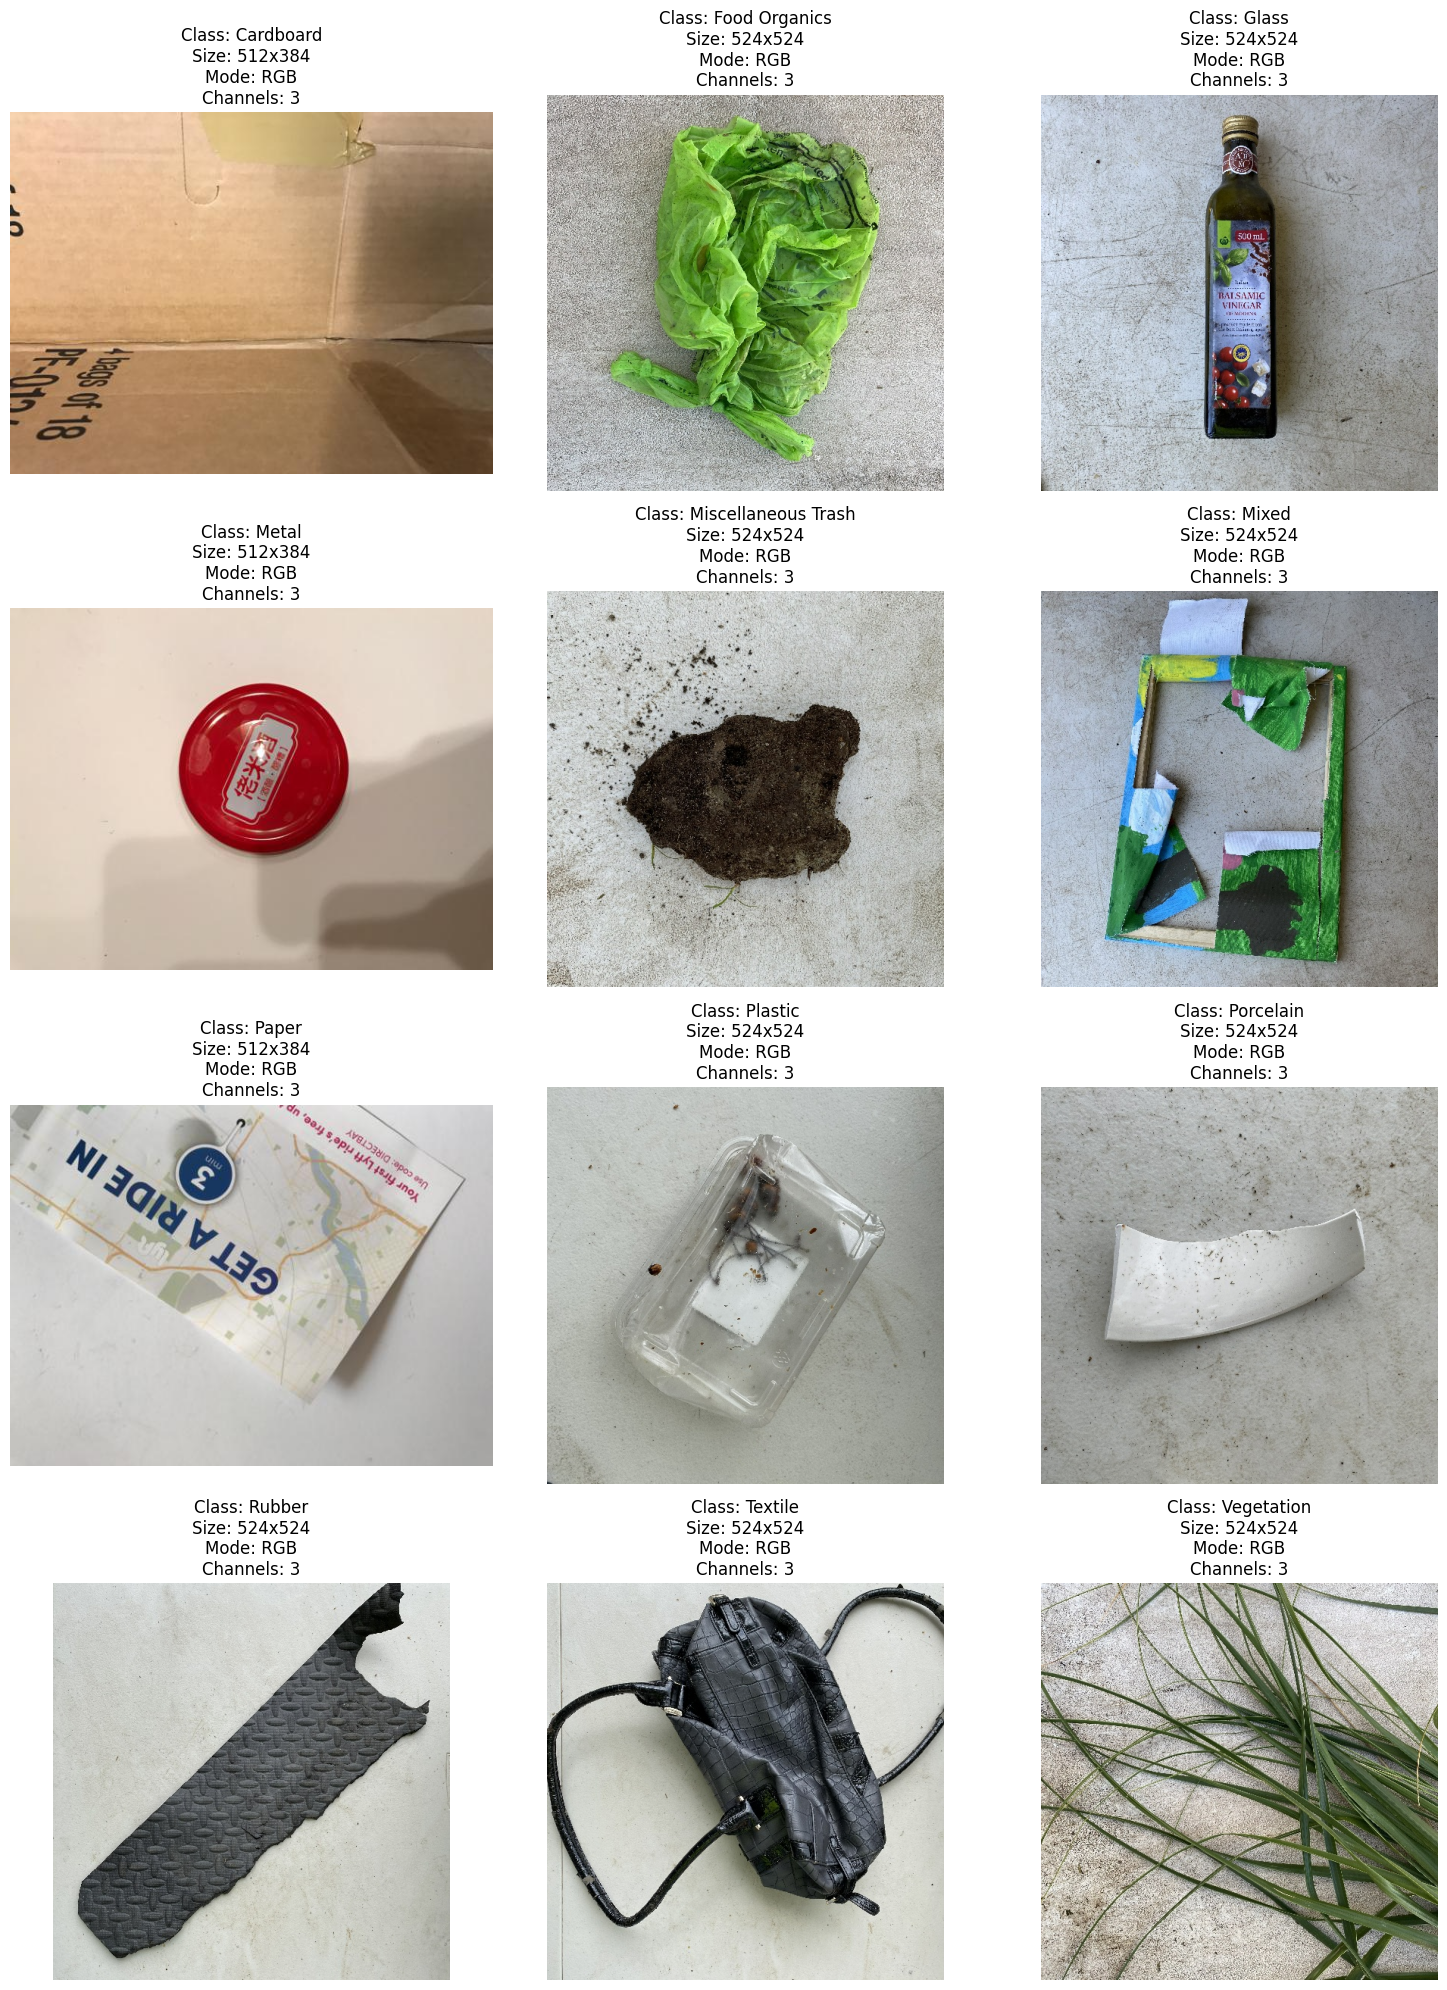

In [14]:
# Get list of image files in the training image folder
image_files = {}
for class_name in os.listdir(root):
    class_dir = os.path.join(root, class_name)
    if os.path.isdir(class_dir):
        image_files[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.jpg')]

# Sample one random image from each class
sample_images = {}
for class_name, images in image_files.items():
    sample_images[class_name] = np.random.choice(images, 1, replace=False)[0]

# Plot the sample images along with their properties
num_classes = len(sample_images)
num_cols = 3
num_rows = (num_classes + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, (ax, (class_name, image_path)) in enumerate(zip(axes.flat, sample_images.items())):
    # Open the image using PIL
    img = Image.open(image_path)
    # Get image properties
    width, height = img.size
    mode = img.mode  # Color mode (e.g., RGB, grayscale)
    depth = img.bits  # Depth of the image (bits per pixel)
    channels = len(img.getbands())  # Number of color channels

    # Display the image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class: {class_name}\nSize: {width}x{height}\nMode: {mode}\nChannels: {channels}")

plt.tight_layout()
plt.show()


Data Analysis

C:\Users\reyha\AppData\Local\Temp\ipykernel_12984\1844673426.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60)


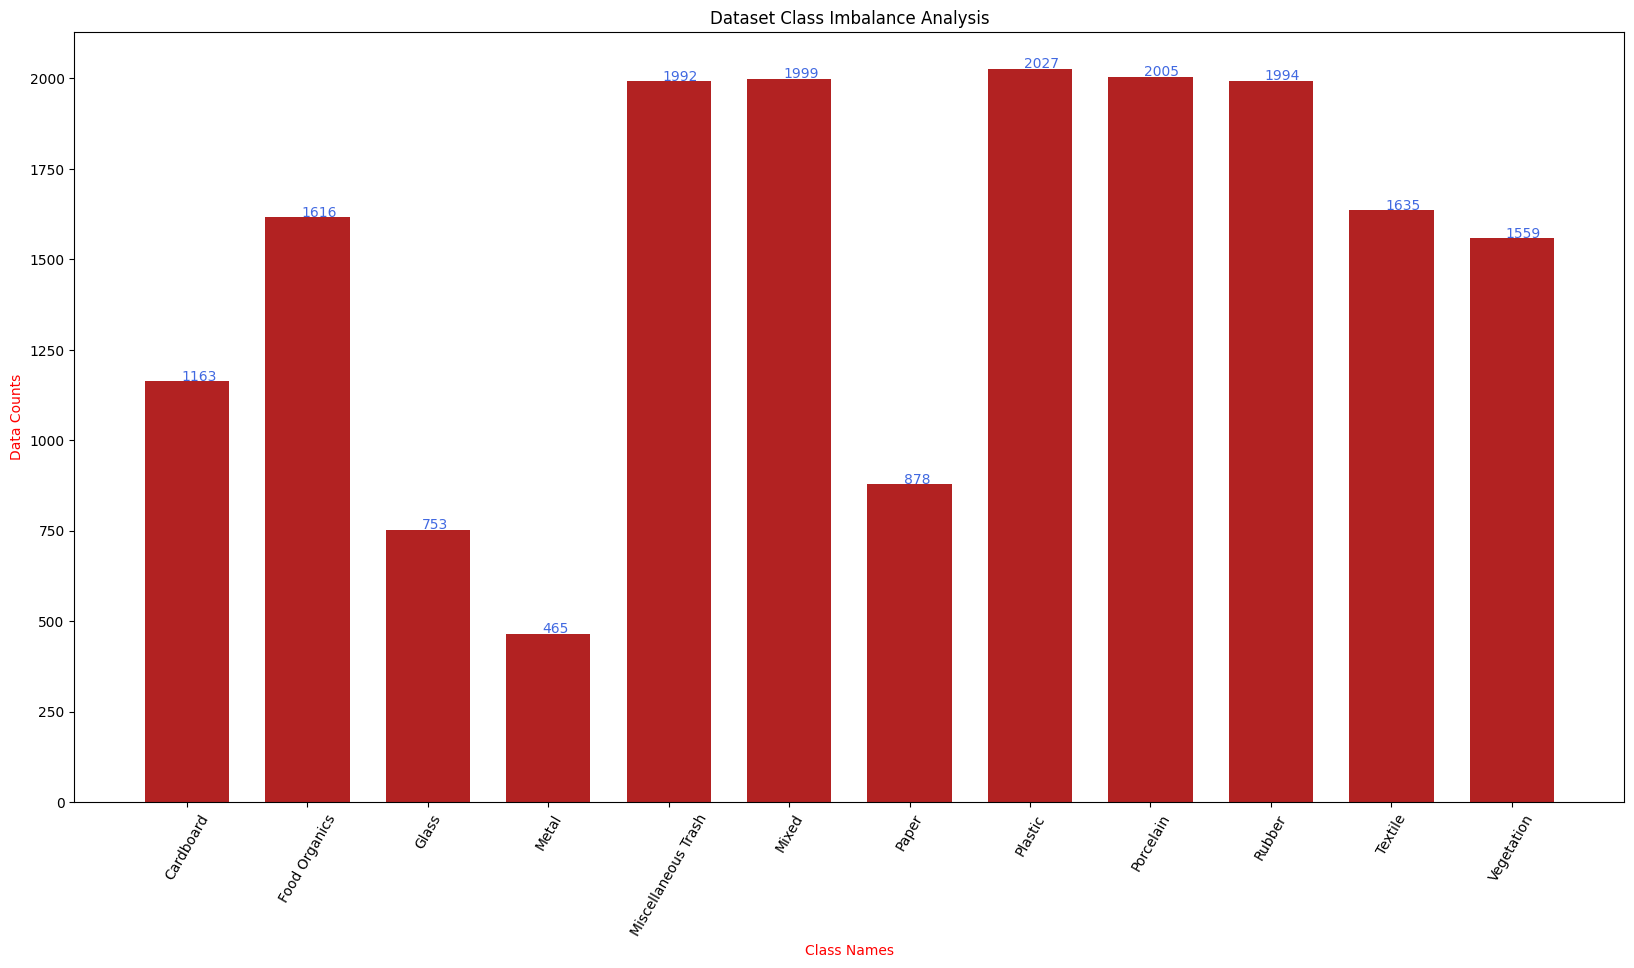

In [15]:
def data_analysis(root, transformations):
    
    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, transformations = tfs)

In [22]:
# # Initialize WandB with existing project
# wandb.init(project="real-waste-project", entity="eunoiawiira")

# Create an instance of the RexNet150 model
num_classes = 12  # Adjust based on the number of classes in your dataset
model = timm.create_model("rexnet_150", pretrained=True, num_classes=num_classes)

# Print the model architecture
print(model)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))

# # Log model to WandB
# wandb.watch(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tr_dl:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(tr_dl)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

        # wandb.log({"Train Loss": loss.item()})

# Test the model
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in ts_dl:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print the accuracy
    print('Epoch [{}/{}], Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, 100*correct/total))

# Save the model
model_path = "eunoiawiira_vgg11_finetuned.pth"
torch.save(model.state_dict(), model_path)

# # 🐝 Close your wandb run
# wandb.finish()

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene